In [1]:
%reset -f

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import root_scalar
from scipy.io import loadmat

In [3]:
data = loadmat("SeriesDATA.mat")
data.pop("__header__")
data.pop("__version__")
data.pop("__globals__")

[]

In [4]:
df = pd.DataFrame({k: np.ravel(v) for k, v in data.items()})

In [7]:
import numpy as np
from scipy.optimize import root_scalar

# === 1. given or estimated from data ===
a = np.mean(df["DivGrowth"])                 
s2_d = np.var(np.log(df["DivGrowth"]))
sd = np.sqrt(s2_d)         
sc = sd / 7
rho = 0.2                
rf_gross = df["rb"].to_numpy()  
Rf = np.mean(rf_gross)                      
pd_data = np.mean(df["PD"])

# === 2. print parameters ===
print("=" * 50)
print("Model Parameters:")
print("=" * 50)
print(f"Mean gross return (a):        {a:.4f}")
print(f"Std dev log div growth (sd):  {sd:.4f}")
print(f"Std dev log cons growth (sc): {sc:.4f}")
print(f"Correlation (rho):            {rho:.4f}")
print(f"Mean risk-free rate (Rf):     {Rf:.4f}")
print(f"Empirical P/D ratio:          {pd_data:.2f}")
print("=" * 50)

# === 3. model functions ===
def rho_e(gamma, sc, sd, rho):
    return np.exp(0.5 * gamma * (1 + gamma) * sc**2 - gamma * rho * sc * sd)

def delta_from_gamma(gamma, a, sc, Rf):
    return (Rf ** -1) * (a ** gamma) * np.exp(-0.5 * gamma * (1 + gamma) * sc**2)

def pd_ratio_model(gamma, a, sd, sc, rho, Rf):
    delta = delta_from_gamma(gamma, a, sc, Rf)
    rhoE = rho_e(gamma, sc, sd, rho)
    numerator = delta * (a ** (1 - gamma)) * rhoE
    denominator = 1 - (a ** (1 - gamma)) * rhoE
    return numerator / denominator

# === 3. root-finding objective ===
def objective(gamma):
    return pd_ratio_model(gamma, a, sd, sc, rho, Rf) - pd_data

# === 4. solve for gamma ===
sol = root_scalar(objective, bracket=[0.9999, 200], method='bisect')
gamma_star = sol.root
delta_star = delta_from_gamma(gamma_star, a, sc, Rf)

print(f"Calibrated gamma = {gamma_star:.4f}")
print(f"Implied delta   = {delta_star:.4f}")
print(f"Model P/D check = {pd_ratio_model(gamma_star, a, sd, sc, rho, Rf):.2f}")


Model Parameters:
Mean gross return (a):        1.0040
Std dev log div growth (sd):  0.0296
Std dev log cons growth (sc): 0.0042
Correlation (rho):            0.2000
Mean risk-free rate (Rf):     1.0013
Empirical P/D ratio:          127.68
Calibrated gamma = 2.9695
Implied delta   = 1.0106
Model P/D check = 127.68


In [8]:
print(f"\nDelta range check:")
print(f"Delta at gamma=1:   {delta_from_gamma(1, a, sc, Rf):.4f}")
print(f"Delta at gamma=10:  {delta_from_gamma(10, a, sc, Rf):.4f}")
print(f"Delta at gamma=50:  {delta_from_gamma(50, a, sc, Rf):.4f}")


Delta range check:
Delta at gamma=1:   1.0027
Delta at gamma=10:  1.0386
Delta at gamma=50:  1.1934


In [13]:
print(f"\nParameter diagnostics:")
print(f"a (mean gross div growth) = {a:.6f}")
print(f"sc (cons volatility) = {sc:.6f}")
print(f"sc^2 = {sc**2:.8f}")
print(f"Rf (risk-free rate) = {Rf:.6f}")
print(f"1/Rf = {1/Rf:.6f}")

# Check the components separately
gamma_test = 50
print(f"\nAt gamma = {gamma_test}:")
print(f"1/Rf term = {1/Rf:.6f}")
print(f"a^gamma term = {a**gamma_test:.6f}")
exp_term = np.exp(-0.5 * gamma_test * (1 + gamma_test) * sc**2)
print(f"exp() dampening term = {exp_term:.6f}")
print(f"Product (delta) = {(1/Rf) * (a**gamma_test) * exp_term:.6f}")


Parameter diagnostics:
a (mean gross div growth) = 1.004027
sc (cons volatility) = 0.004229
sc^2 = 0.00001788
Rf (risk-free rate) = 1.001331
1/Rf = 0.998671

At gamma = 50:
1/Rf term = 0.998671
a^gamma term = 1.222553
exp() dampening term = 0.977459
Product (delta) = 1.193407


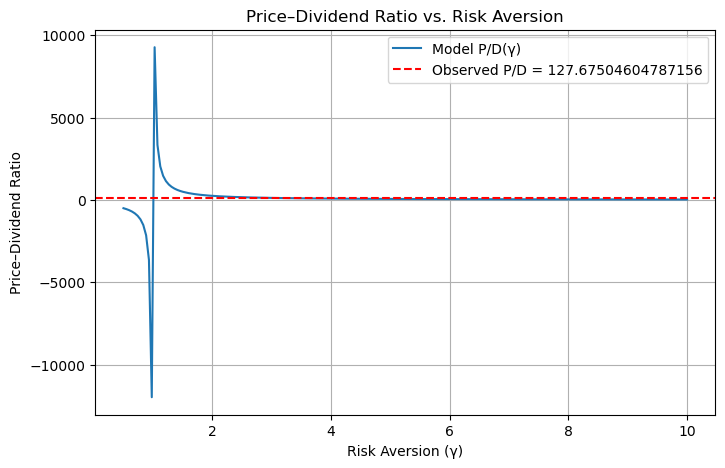

In [10]:
import numpy as np
import matplotlib.pyplot as plt

gammas = np.linspace(0.5, 10, 200)   # range of risk aversion values
pd_model_vals = [pd_ratio_model(g, a, sd, sc, rho, Rf) for g in gammas]

plt.figure(figsize=(8,5))
plt.plot(gammas, pd_model_vals, label="Model P/D(γ)")
plt.axhline(pd_data, color='r', linestyle='--', label=f"Observed P/D = {pd_data}")
plt.xlabel("Risk Aversion (γ)")
plt.ylabel("Price–Dividend Ratio")
plt.title("Price–Dividend Ratio vs. Risk Aversion")
plt.legend()
plt.grid(True)
plt.show()


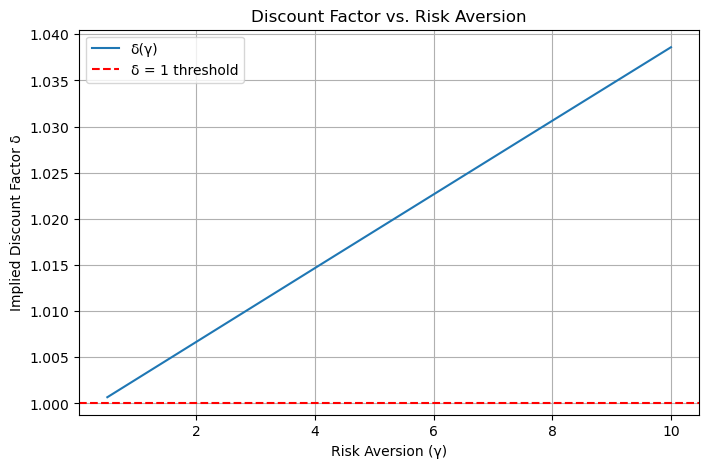

In [11]:
deltas = [delta_from_gamma(g, a, sc, Rf) for g in gammas]

plt.figure(figsize=(8,5))
plt.plot(gammas, deltas, label="δ(γ)")
plt.axhline(1.0, color='r', linestyle='--', label="δ = 1 threshold")
plt.xlabel("Risk Aversion (γ)")
plt.ylabel("Implied Discount Factor δ")
plt.title("Discount Factor vs. Risk Aversion")

plt.legend()
plt.grid(True)
plt.show()


In [12]:
import numpy as np
cross_idx = np.argmin(np.abs(np.array(deltas) - 1))
print(f"δ ≈ 1 at γ ≈ {gammas[cross_idx]:.2f}")


δ ≈ 1 at γ ≈ 0.50
